In [1]:
import numpy as np

In [2]:
from sklearn.datasets import fetch_openml
mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

Datasets from sklearn.datasets tend to have these three keys
- DESCR - describing the dataset
- data - one row per instance one column per feature
- target - array with labels

In [3]:
X, y = mnist["data"], mnist["target"]
print(X.shape)
print(y.shape)

(70000, 784)
(70000,)


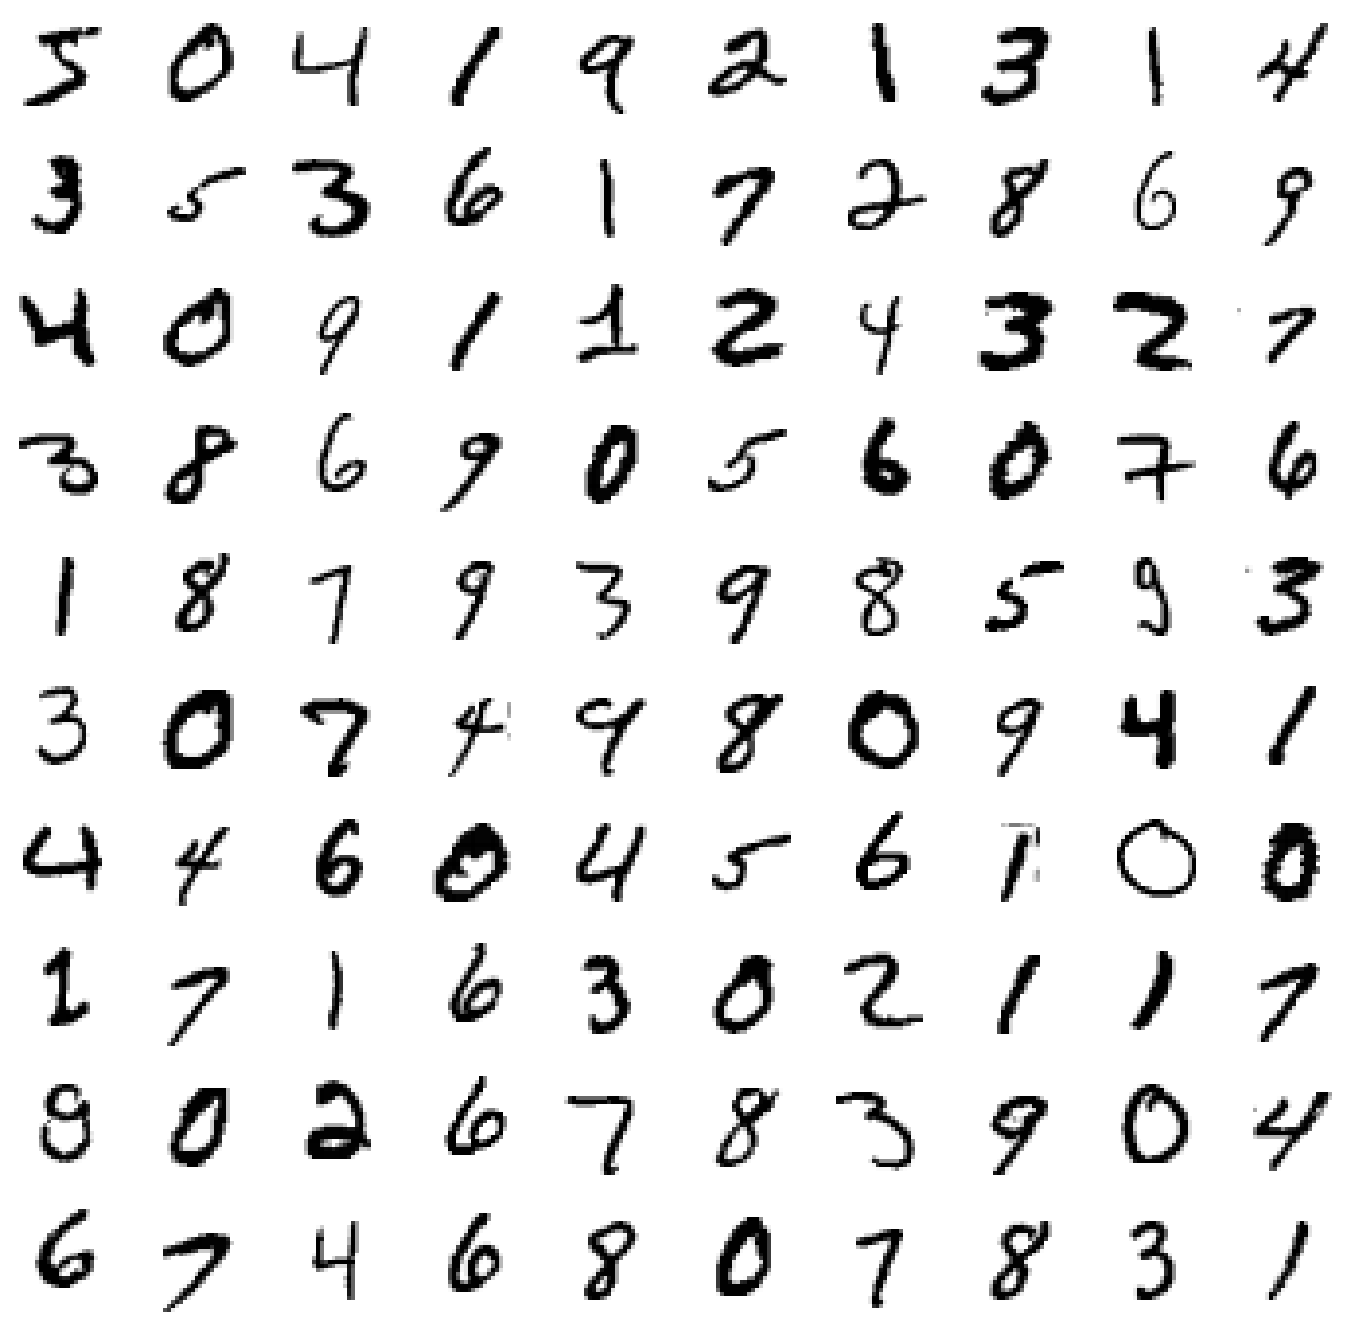

In [4]:
%matplotlib inline
import matplotlib as mpl
from matplotlib import pyplot as plt

fig = plt.figure(figsize=(24, 24))  # width, height in inches

for i in range(100):
    some_digit = X.loc[i].values
    some_digit_image = some_digit.reshape(28,28)

    sub = fig.add_subplot(10, 10, i + 1)
    sub.imshow(some_digit_image, cmap='binary')
    sub.axis("off")

plt.show()

In [5]:
y[0]

'5'

In [6]:
y = y.astype(np.uint8)

Premade test and train set

In [7]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

# Binary Classifier

Create a 5 detector rather than anything else

In [8]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5)

Stochastic Gradient Descent classifier

In [9]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

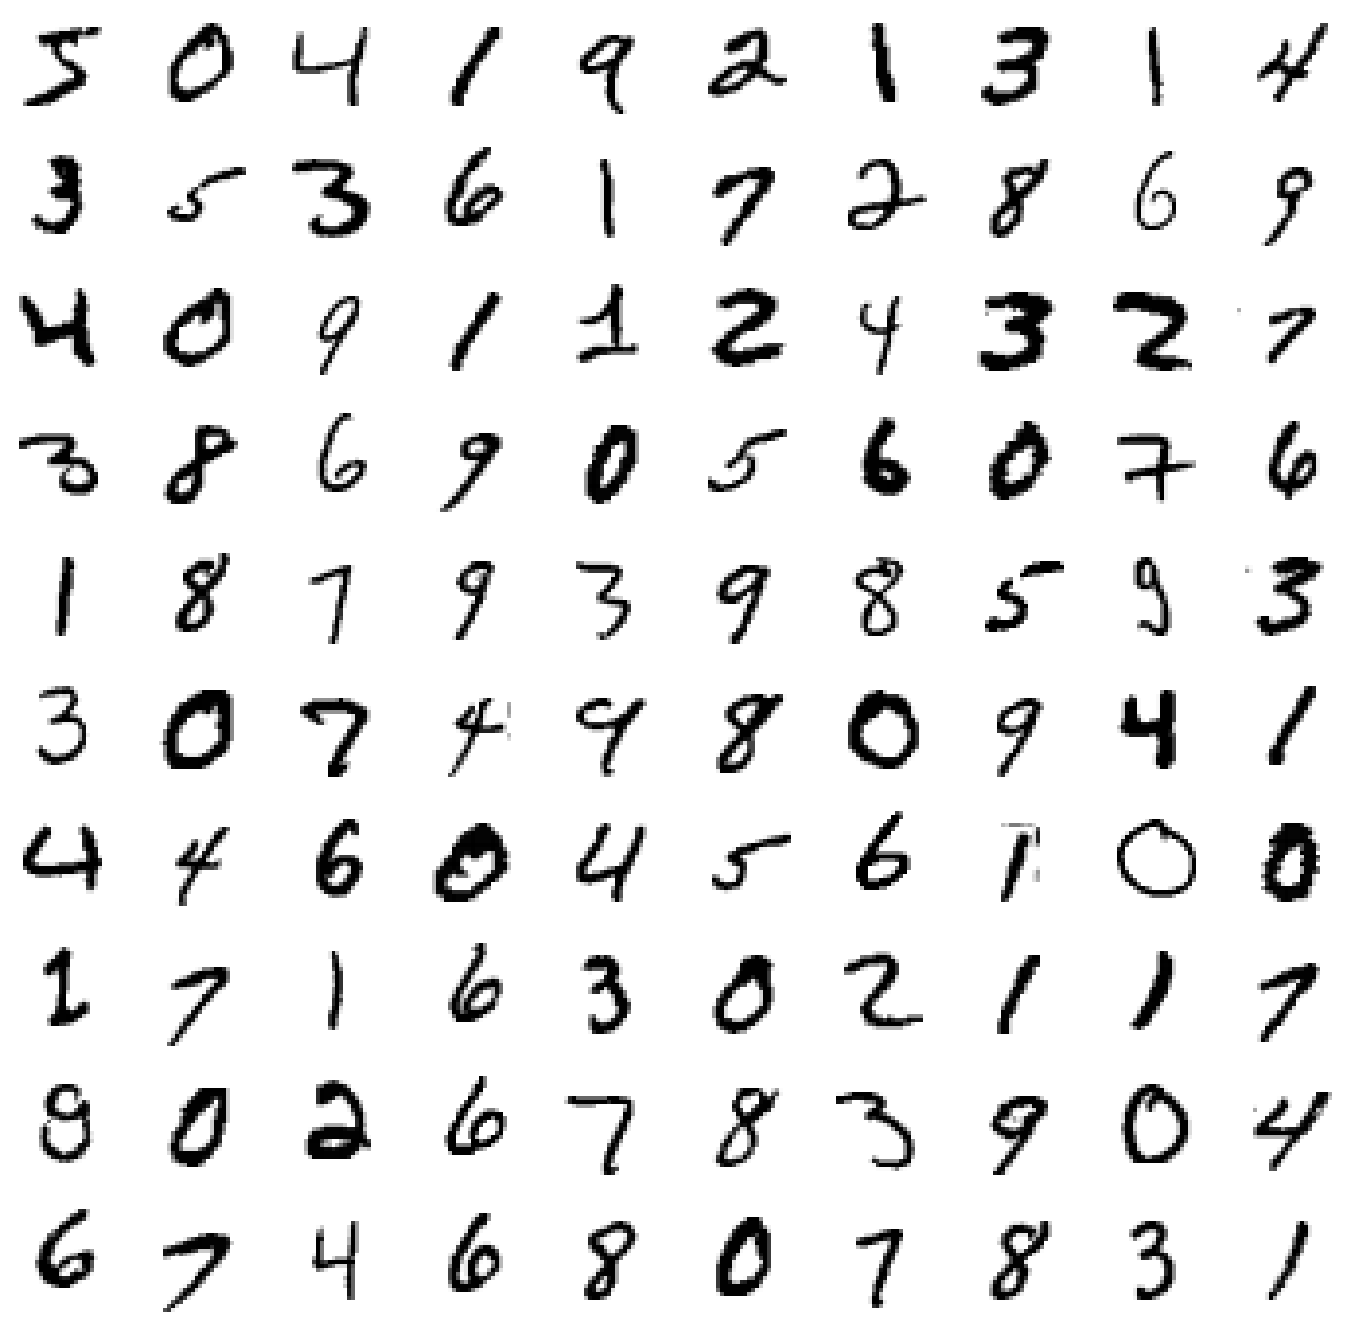

ValueError: cannot reshape array of size 10 into shape (10,10)

In [40]:
fig = plt.figure(figsize=(24, 24))  # width, height in inches

for i in range(100):
    some_digit = X_train.loc[i].values
    some_digit_image = some_digit.reshape(28,28)

    sub = fig.add_subplot(10, 10, i + 1)
    sub.imshow(some_digit_image, cmap='binary')
    sub.axis("off")

plt.show()

sgd_clf.predict(X_train[1040:1050]).reshape(10,10)

# Performance Measures

In [11]:
from sklearn.model_selection import cross_val_score
cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

In [12]:
from sklearn.model_selection import cross_val_predict

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)

In [13]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]])

Precision = $\frac{TP}{TP + FP}$

Recall = $\frac{TP}{TP + FN}$

In [14]:
from sklearn.metrics import precision_score, recall_score
precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [15]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

$F_1$, the harmonic mean of precision and recall, = $2\times\frac{precision\times recall}{precision + recall}$

In [16]:
from sklearn.metrics import f1_score
f1_score(y_train_5, y_train_pred)

0.7325171197343846

Not always the best performance metric

Can use threshold to affect the recall and precision of the predictor

In [17]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3, method='decision_function')
y_scores

array([  1200.93051237, -26883.79202424, -33072.03475406, ...,
        13272.12718981,  -7258.47203373, -16877.50840447])

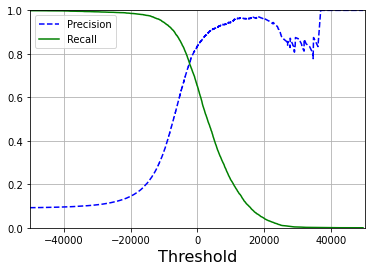

In [18]:
from sklearn.metrics import precision_recall_curve

precisions, recalls, thresholds = precision_recall_curve(y_train_5,y_scores)

def plot_precision_recall_vs_thresholds(precisions, recalls, thresholds):
    plt.plot(thresholds, precisions[:-1], "b--", label="Precision")
    plt.plot(thresholds, recalls[:-1], "g-", label="Recall")
    plt.legend()
    plt.xlabel("Threshold", fontsize=16)        # Not shown
    plt.grid(True)                              # Not shown
    plt.axis([-50000, 50000, 0, 1])             # Not shown
    # add more stuff
    
plot_precision_recall_vs_thresholds(precisions, recalls, thresholds)
plt.show()

## The Roc Curve

The reciever operating characteristic (ROC) curve is another common tool used with binary classifiers.

The ROC curve plots the true positive rate (recall) against the false positive rate.

In [19]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

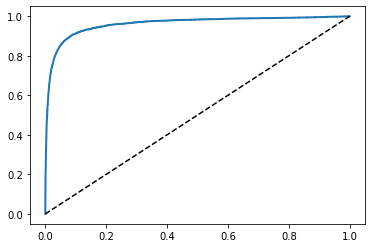

In [20]:
def plot_roc_curve(fpr,tpr,label=None):
    plt.plot(fpr,tpr,linewidth=2,label=label)
    plt.plot([0,1], [0,1], 'k--')
    
plot_roc_curve(fpr, tpr)
plt.show()

One way to compare classifiers is to measure the area under the curve. A perfect ROC will have a score equal to 1 and a random classifier will have a score of 1/2

In [21]:
from sklearn.metrics import roc_auc_score
roc_auc_score(y_train_5, y_scores)

0.9604938554008616

Train a RandomForestClassifier and get the probabilities of each choice.

In [22]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier(random_state=42)
y_probas_forest = cross_val_predict(forest_clf, X_train, y_train_5, cv=3, method='predict_proba')

In [23]:
y_scores_forest = y_probas_forest[:, 1] # score = proba of positive class
fpr_forest, tpr_forest, thresholds_forest = roc_curve(y_train_5, y_scores_forest)

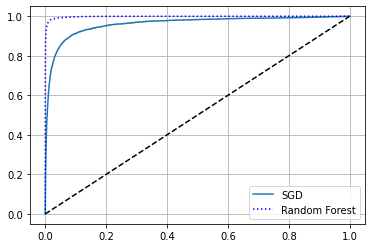

In [24]:
plt.plot(fpr,tpr, label='SGD')
plt.plot(fpr_forest,tpr_forest, 'b:', label='Random Forest')
plt.plot([0,1], [0,1], 'k--')
plt.legend()
plt.grid()
plt.show()

In [25]:
forest_clf.fit(X_train, y_train_5)
y_pred_forest = forest_clf.predict(X_test)


f1_score(y_test_5, y_pred_forest)

0.926391382405745

# Multiclass Classification

Multiclass Classifiers can distinguish between more than just True and False

Two Strategies for combining binary classifiers to make a multiclass classifier
- One vs The Rest
  - You make 1 binary classifiers for each classification class (True or False). You then compile them to choose the most certain output 
- One vs One
  - You create a binary classifier for each pair of classification classes. You then compile the results.

sklearn automatically runs OvO or OvR if you use a binary classifier on multiclass data

In [26]:
from sklearn.svm import SVC
svm_clf = SVC()
svm_clf.fit(X_train, y_train)
svm_clf.predict([some_digit])

array([1], dtype=uint64)

In [27]:
some_digit_scores = svm_clf.decision_function([some_digit])
some_digit_scores

array([[-0.30727308,  9.31003099,  6.22374339,  3.09511851,  6.15897488,
         1.71471474,  0.69542629,  8.29964841,  4.12604772,  6.22776651]])

In [28]:
np.argmax(some_digit_scores)

1

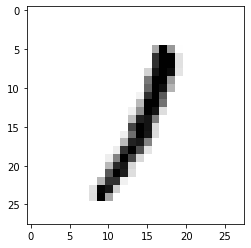

In [29]:
plt.imshow(some_digit_image, cmap='binary')

In [30]:
from sklearn.multiclass import OneVsRestClassifier

ovr_clf = OneVsRestClassifier(SVC())
ovr_clf.fit(X_train, y_train)
ovr_clf.predict([some_digit])

array([1], dtype=uint64)

In [32]:
some_digit_scores = ovr_clf.decision_function([some_digit])
some_digit_scores

array([[-2.49842396,  1.16725318, -1.69854165, -1.20687322, -1.32479237,
        -2.11435093, -2.79964166, -1.10541191, -2.14740406, -1.95777951]])

In [36]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier()
sgd_clf.fit(X_train, y_train)
sgd_clf.predict([some_digit])

array([1], dtype=uint64)

In [37]:
from sklearn.ensemble import RandomForestClassifier

forest_clf = RandomForestClassifier()
forest_clf.fit(X_train, y_train)
forest_clf.predict([some_digit])

array([1], dtype=uint64)

In [38]:
print(cross_val_score(svm_clf, X_test, y_test, cv=3, scoring='accuracy'))
print(cross_val_score(ovr_clf, X_test, y_test, cv=3, scoring='accuracy'))
print(cross_val_score(sgd_clf, X_test, y_test, cv=3, scoring='accuracy'))
print(cross_val_score(forest_clf, X_test, y_test, cv=3, scoring='accuracy'))

[0.93491302 0.95229523 0.96669667]
[0.93641272 0.95229523 0.96249625]
[0.82813437 0.85688569 0.87218722]
[0.92021596 0.94209421 0.9549955 ]
